# Time lagged-autoencoder using Recurrent Neural Networks

### In order to install TF 2,0 on google colab uncomment and run below code line 

In [0]:
# !pip install -q tensorflow==2.0.0-alpha0

# Imports

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RepeatVector, TimeDistributed, SimpleRNN, Dropout, LeakyReLU
from tensorflow import keras
import tensorflow as tf
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import permutations
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D


# Prepare data

## Get data from provided file

In [0]:
def get_data():
    with np.load('dimredux-challenge-01-data.npz') as fh:
        data_x = fh['data_x']
        validation_x = fh['validation_x']
        validation_y = fh['validation_y']


    return data_x, validation_x, validation_y

## Generate train and validation data

In [0]:
data_x, validation_x, validation_y = get_data()

data_x = data_x.astype('float32')

original_data_x = np.copy(data_x)
TAU = 8

data_x = original_data_x[:-TAU]
shifted_data_x = original_data_x[TAU:]


In [5]:
print(f"original_data_x shape: {original_data_x.shape}")
print(f"data_x shape: {data_x.shape}")
print(f"shifted_data_x shape: {shifted_data_x.shape}")
print(f"validation_x shape: {validation_x.shape}")
print(f"validation_y shape: {validation_y.shape}")

original_data_x shape: (100000, 3)
data_x shape: (99992, 3)
shifted_data_x shape: (99992, 3)
validation_x shape: (1000, 3)
validation_y shape: (1000,)


# Visualize original data

## Visualize training data

### Visualization 3D

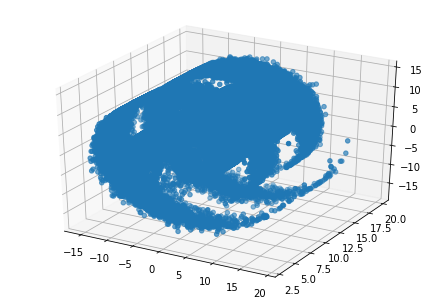

In [6]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(data_x[:, 0], data_x[:, 1], data_x[:, 2])
pyplot.show()

### Vizualize 2D

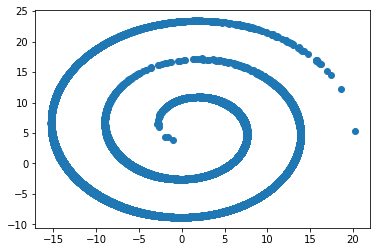

In [7]:
pca = PCA(n_components=2)
principal_components_original_x = pca.fit_transform(original_data_x)

plt.scatter(principal_components_original_x[:, 0], principal_components_original_x[:, 1])
plt.show()

## Visualize validation data

### Visualization 3D

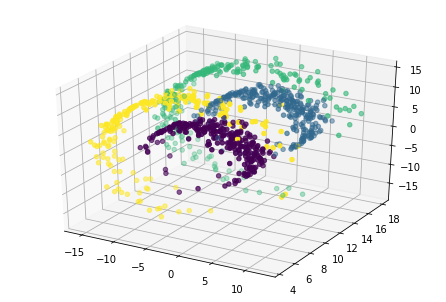

In [8]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(validation_x[:, 0], validation_x[:, 1], validation_x[:, 2], c=validation_y)
pyplot.show()

### Visualization 2D

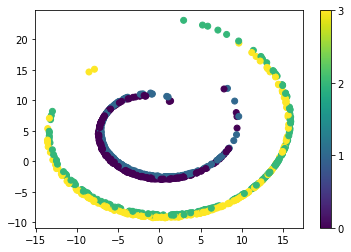

In [9]:
pca = PCA(n_components=2)
principal_components_validation_x = pca.fit_transform(validation_x)

plt.scatter(principal_components_validation_x[:, 0], principal_components_validation_x[:, 1], c=validation_y)
plt.colorbar(ticks=np.linspace(0,3,4))
plt.show()

## Make data zero-mean

In [0]:
data_x = data_x - np.mean(data_x, axis=0)
shifted_data_x =  shifted_data_x - np.mean(shifted_data_x, axis=0)
original_data_x = original_data_x -  np.mean(original_data_x, axis=0)
validation_x = validation_x - np.mean(validation_x, axis=0)

## Whitten data

In [0]:
pca_whiten = PCA(whiten=True)

data_x = pca_whiten.fit_transform(data_x)
shifted_data_x = pca_whiten.fit_transform(shifted_data_x)
original_data_x = pca_whiten.fit_transform(original_data_x)
validation_x = pca_whiten.fit_transform(validation_x)

# Visualize data after transformations

## Visualize training data

### Visualization 3D

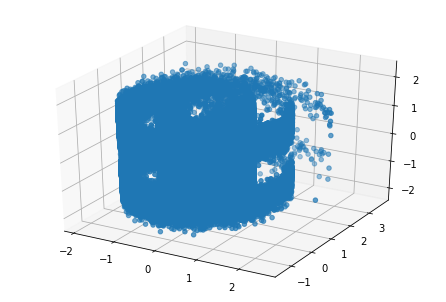

In [12]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(data_x[:, 0], data_x[:, 1], data_x[:, 2])
pyplot.show()

### Visualization 2D

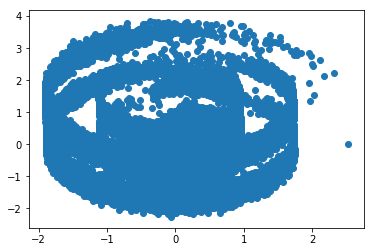

In [13]:
pca = PCA(n_components=2)
principal_components_data_x = pca.fit_transform(data_x)

plt.scatter(principal_components_data_x[:, 0], principal_components_data_x[:, 1])
plt.show()

## Visualize validation data

### Visualization 3D

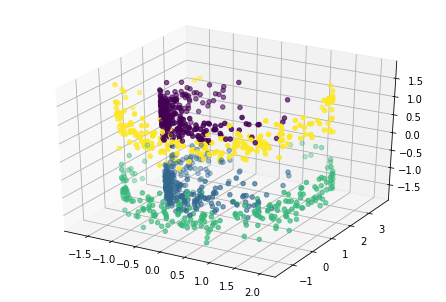

In [14]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(validation_x[:, 0], validation_x[:, 1], validation_x[:, 2], c=validation_y)
pyplot.show()

### Visualization 2D

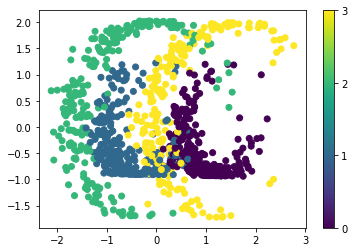

In [15]:
pca = PCA(n_components=2)
principal_components_validation_x = pca.fit_transform(validation_x)

plt.scatter(principal_components_validation_x[:, 0], principal_components_validation_x[:, 1], c=validation_y)
plt.colorbar(ticks=np.linspace(0,3,4))
plt.show()

## Expand dims in order to use it with RNNs

In [0]:
data_x = np.expand_dims(data_x, axis=2)
shifted_data_x = np.expand_dims(shifted_data_x, axis=2)
original_data_x = np.expand_dims(original_data_x, axis=2)
validation_x = np.expand_dims(validation_x, axis=2)

## Define training parameters

In [0]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
EPOCHS = 120

## Dataset API 

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((data_x, shifted_data_x)).batch(BATCH_SIZE)

# Prepare model

In [0]:
def get_model():
    encoder_input = keras.Input(shape=(3, 1), name='input')
    x = SimpleRNN(200, return_sequences = True)(encoder_input)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    x = SimpleRNN(100,return_sequences = True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)


    x = SimpleRNN(1, name="hidden_state", return_sequences = False)(x)
    hidden_state = LeakyReLU()(x)


    encoder = keras.Model(encoder_input, hidden_state, name="encoder")

    x = RepeatVector(3)(hidden_state)

    x = SimpleRNN(100, return_sequences=True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    x = SimpleRNN(200, return_sequences=True)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    decoder_output = TimeDistributed(Dense(1))(x)

    auto_encoder = keras.Model(encoder_input, decoder_output, name="auto_encoder")

    return auto_encoder, encoder

## Model summary

In [20]:
model, encoder = get_model()

model.summary()

print()

encoder.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 1)]            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 3, 200)            40400     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3, 200)            0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 200)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 3, 100)            30100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3, 100)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 100)           

# Training 

## Define loss function and optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
loss = tf.keras.losses.MeanSquaredError()

## Define accuracy measurement method

In [0]:
def get_accuracy(prediction, validation):
    """
    Function returns prediction accuracy value. We know only which data point belongs to which class, but we don't know 
    in whcih order data were labeled in validation set we need to check all combinations and take best one
    :param prediction: np.array(N,), preditions after clastering 
    :param validation:  np.array(N,) expected labels 
    :return: scalar, accuracy of predicted classes 
    """
    accuracies = []
    
    for permutation in permutations([0, 1, 2, 3]):
        current_validation_permutation = np.zeros_like(validation)
        c1, c2, c3, c4 = permutation
        
        current_validation_permutation[validation == 0] = c1
        current_validation_permutation[validation == 1] = c2
        current_validation_permutation[validation == 2] = c3
        current_validation_permutation[validation == 3] = c4
        
        difference = prediction - current_validation_permutation
        
        acc_val = (1 - np.count_nonzero(difference) / len(difference))
        
        accuracies.append(acc_val)
        
    return max(accuracies)

## Get classes from claster

In [0]:
def get_classes_from_claster(data_points):
    return KMeans(n_clusters=4).fit(data_points).labels_

## Launch training

In [24]:
model.compile(optimizer=optimizer, loss=loss)
model.fit(dataset, epochs=EPOCHS, verbose=2)


W0615 16:24:23.356091 140169475610496 training_utils.py:1353] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 1/120
782/782 - 19s - loss: 0.9669
Epoch 2/120
782/782 - 16s - loss: 0.9464
Epoch 3/120
782/782 - 16s - loss: 0.9366
Epoch 4/120
782/782 - 16s - loss: 0.9308
Epoch 5/120
782/782 - 16s - loss: 0.9264
Epoch 6/120
782/782 - 16s - loss: 0.9236
Epoch 7/120
782/782 - 16s - loss: 0.9206
Epoch 8/120
782/782 - 16s - loss: 0.9187
Epoch 9/120
782/782 - 16s - loss: 0.9172
Epoch 10/120
782/782 - 16s - loss: 0.9160
Epoch 11/120
782/782 - 16s - loss: 0.9150
Epoch 12/120
782/782 - 17s - loss: 0.9137
Epoch 13/120
782/782 - 16s - loss: 0.9127
Epoch 14/120
782/782 - 16s - loss: 0.9124
Epoch 15/120
782/782 - 16s - loss: 0.9116
Epoch 16/120
782/782 - 15s - loss: 0.9112
Epoch 17/120
782/782 - 16s - loss: 0.9110
Epoch 18/120
782/782 - 16s - loss: 0.9102
Epoch 19/120
782/782 - 16s - loss: 0.9103
Epoch 20/120
782/782 - 16s - loss: 0.9101
Epoch 21/120
782/782 - 16s - loss: 0.9095
Epoch 22/120
782/782 - 16s - loss: 0.9089
Epoch 23/120
782/782 - 16s - loss: 0.9094
Epoch 24/120
782/782 - 16s - loss: 0.9086
E

# Check accuracy

In [25]:
one_d_projection = encoder.predict(validation_x)
predictions = get_classes_from_claster(one_d_projection)
acc_val = get_accuracy(predictions, validation_y)
print(f"Accuracy on validation dataset {acc_val}")


Accuracy on validation dataset 0.993


# Visualize 1d projection

[]

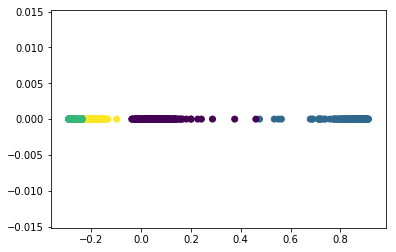

In [26]:
predictions = np.expand_dims(predictions, axis=1)
plt.scatter(one_d_projection, np.zeros_like(one_d_projection), c=predictions)
plt.plot()

# Save models

In [0]:
model.save("autoencoder.h5")
encoder.save("encoder.h5")

# Save 1d prediction resut

In [0]:
np.save('prediction.npy', predictions)